In [116]:
import itertools
import matplotlib.pyplot as plt

In [1]:
from os import walk

from PIL import Image, ImageDraw, ImageFilter, ImageFont
import numpy as np

# Cut the image into individual coins

In [2]:
eur_front = Image.open("../data/coins/euro_front.png")

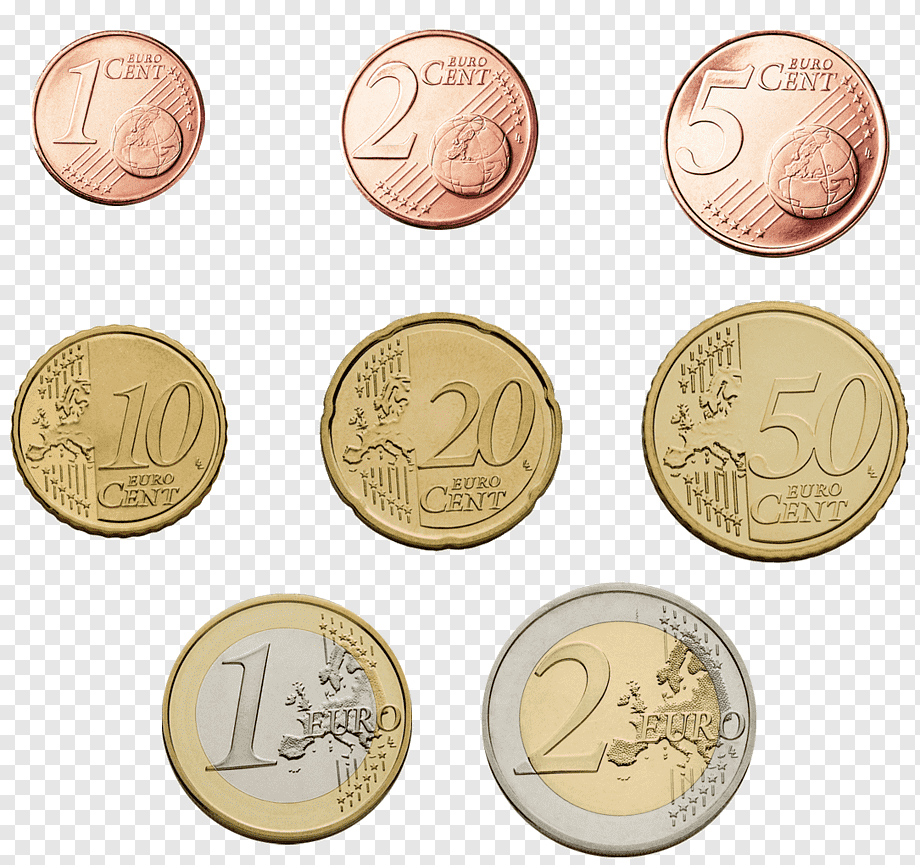

In [3]:
eur_front

In [4]:
coin_pos_dict = {"f_1cent": ((30, 30, 205, 207), 0.01),
            "f_2cent": ((340, 30, 540, 230), 0.02),
            "f_5cent": ((661, 30, 890, 259), 0.05),
            "f_10cent": ((9, 324, 229, 539), 0.1),
            "f_20cent": ((320, 312, 564, 551), 0.2),
            "f_50cent": ((641, 300, 909, 563), 0.5),
            "f_1eur": ((161, 593, 414, 846), 1),
            "f_2eur": ((481, 582, 757, 859), 2)}

In [5]:
coin_img_dict = {}
for name, (pos, value) in coin_pos_dict.items():
    coin_img_dict[name] = (eur_front.crop(pos), value)

# Full Image Creator

In [168]:
def load_random_background(background_folder="../data/background/", base_ratio=500, mobile_camera_ratio=1.6624):
    # mobile_camera_ratio: 2048 x 1232
    # load background
    # get files
    filenames = next(walk(background_folder), (None, None, []))[2]  # [] if no file
    filename = np.random.choice(filenames)
    back = Image.open(background_folder + filename)
    
    # compute crop ratios
    back_w, back_h = back.size
    camera_w = base_ratio * mobile_camera_ratio
    camera_h = base_ratio

    # compute crop dimensions
    left = np.random.randint(back_w - camera_w)
    top = np.random.randint(back_h - camera_h)
    right = camera_w + left
    bottom = camera_h + top

    # Crop image
    crop = back.crop((left, top, right, bottom))
    
    return crop

def compute_area(rectangle):
    dw = rectangle[2] - rectangle[0]
    dh = rectangle[3] - rectangle[1]
    return dw*dh

def compute_overlap_percentage(pos1, pos2):
    left = max(pos1[0], pos2[0])
    top = max(pos1[1], pos2[1])
    right = min(pos1[2], pos2[2])
    bottom = min(pos1[3], pos2[3])
    pos3 = (left, top, right, bottom)
    
    dw = right - left
    dh = bottom - top
    if (dw>=0) and (dh>=0):
        pos1_area = compute_area(pos1)
        pos2_area = compute_area(pos2)
        pos3_area = compute_area(pos3)
        min_area = min(pos1_area, pos2_area)
        return pos3_area/min_area
    else:
        return 0.0

def paste_random_coin(background, coin_img, coin_positions=None, max_coin_overlap_percentage=0.1):
    background_copy = background.copy()
    # get background size
    back_w, back_h = background.size

    # get coin random position
    coin_w, coin_h = coin_img.size
    coin_pos_w = np.random.randint(back_w - coin_w)
    coin_pos_h = np.random.randint(back_h - coin_h)
    coin_pos = (coin_pos_w, coin_pos_h, coin_pos_w+coin_w, coin_pos_h+coin_h)
    
    if coin_positions:
        for old_coin_pos in coin_positions:
            overlap_percentage = compute_overlap_percentage(coin_pos, old_coin_pos[0])
            if overlap_percentage >= max_coin_overlap_percentage:
                return background_copy, None

    # get coin circle mask
    coin_mask = Image.new("L", coin_img.size, 0)
    draw = ImageDraw.Draw(coin_mask)
    draw.ellipse((0, 0, coin_w, coin_h), fill=255)
    coin_mask.filter(ImageFilter.GaussianBlur(10))

    # random rotate coin imgage
    coin_img = coin_img.rotate(np.random.randint(360))

    # paste coin into background
    background_copy.paste(coin_img, (coin_pos_w, coin_pos_h), coin_mask)
    
    return background_copy, coin_pos

def draw_bounding(image, pos, text=None):
    image_copy = image.copy()
    draw = ImageDraw.Draw(image_copy)  
    draw.rectangle(pos, outline ="red")
    
    if text:
        fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", 40)
        draw.text((pos[0],pos[1]), text, font=fnt, fill="red")

    return image_copy

def crop_coins(background, coin_positions, crop_noise=0.05):
    coins = []
    for pos, value in coin_positions:
        noised_pos = np.random.uniform(-crop_noise,crop_noise, 4) * pos
        pos = pos + noised_pos
        coins.append((background.crop(pos), value))
    return coins

def generate_image(coins_dict, n_coins=25):
    back_img = load_random_background(base_ratio=600)

    coin_resize_base = min(max(0.4, np.random.rand()),0.6)

    coins = np.empty(len(coins_dict), dtype=object)
    coins[:] = list(coins_dict.values())

    coin_positions = []
    for coin, value in np.random.choice(coins, size=n_coins):
        coin_w, coin_h = coin.size
        coin = coin.resize(
            (int(coin_w * coin_resize_base), int(coin_h * coin_resize_base)),
            resample=Image.LANCZOS,
        )
        back_img, coin_pos = paste_random_coin(back_img, coin, coin_positions=coin_positions, max_coin_overlap_percentage=0.33)
        if coin_pos:
            coin_positions.append([coin_pos, value])

    return back_img, coin_positions

Total value:  4.95


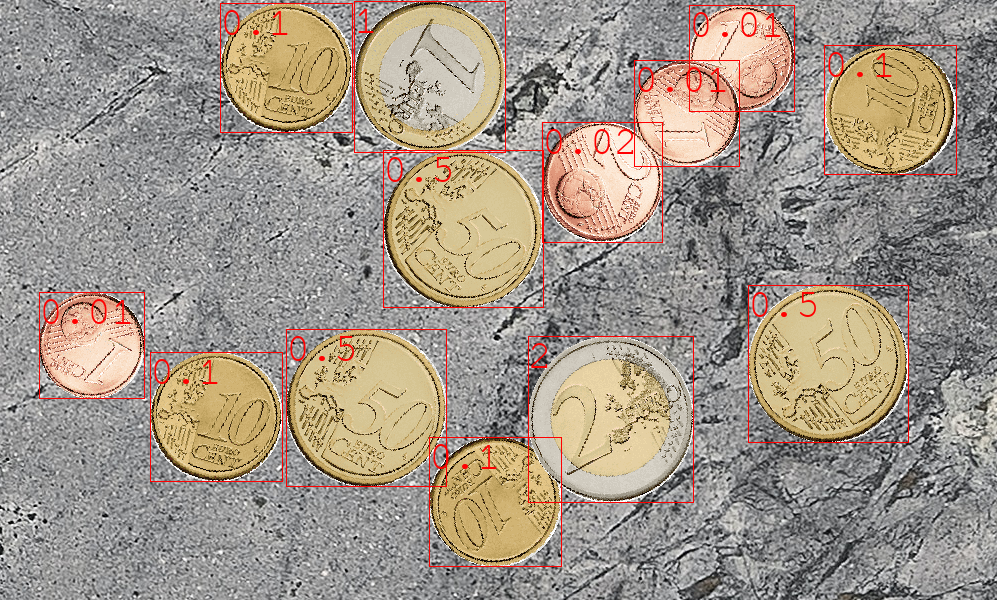

In [169]:
back_img, coin_positions = generate_image(coin_img_dict)

crop_coins_img = crop_coins(back_img, coin_positions)
    
total = 0
for pos, value in coin_positions:
    back_img = draw_bounding(back_img, pos, str(value))
    total += value

print("Total value: ", total)
back_img

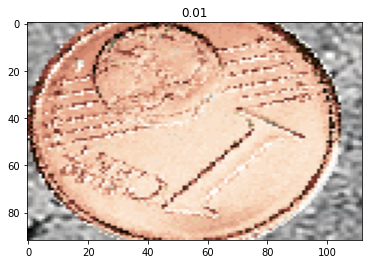

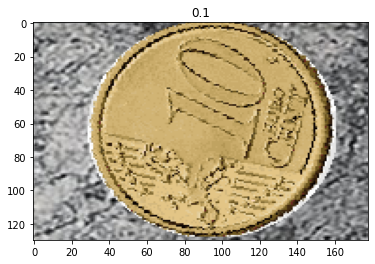

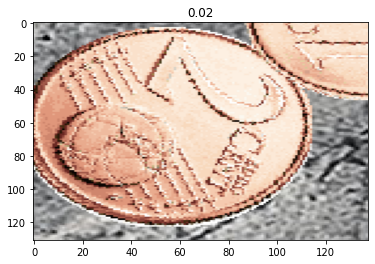

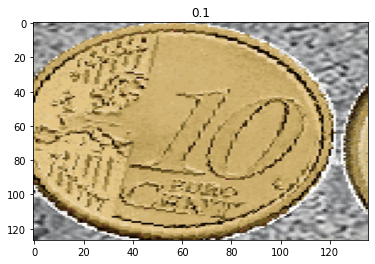

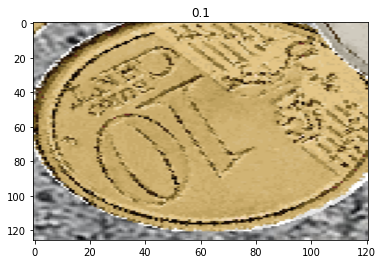

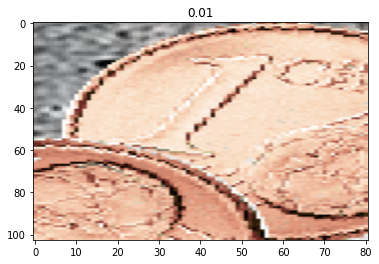

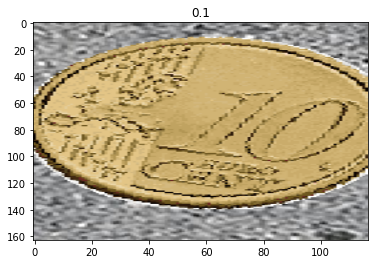

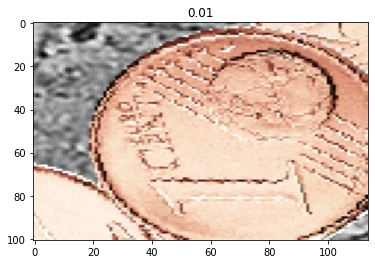

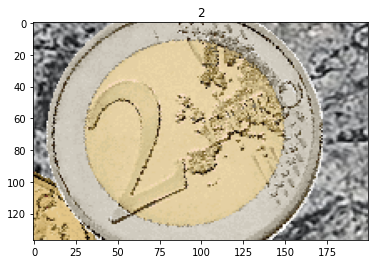

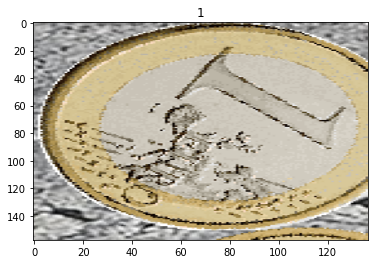

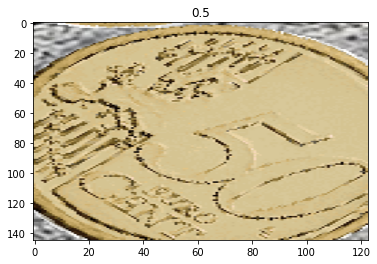

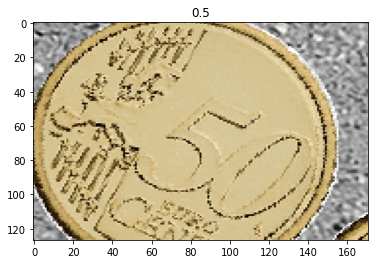

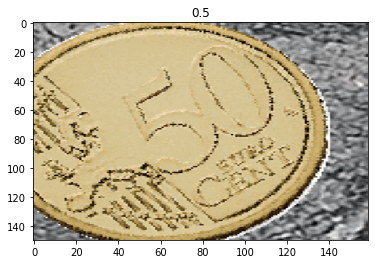

In [170]:
for img, value in crop_coins_img:
    plt.imshow(np.asarray(img), aspect="auto")
    plt.title(value)
    plt.show()